# Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Rice_Cammeo_Osmancik.csv', sep=';', decimal=',')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


# EDA

Meaning of the columns [1]:
- Area: Number of pixels within the boundaries of the rice grain.
- Perimeter: Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain.
- Major Axis Length: The longest line that can be drawn on the rice grain.
- Minor Axis Length: The shortest line that can be drawn on the rice  grain.
- Eccentricity: It measures how round the ellipse is
- Convex Area: Number of pixels count of the smallest convex shell of the region formed by the rice grain.
- Extent: Ratio of the region formed by the rice grain to the bounding box pixels.
- Class (target): Rice Variety (Cammeo or Osmancik).

### Basic information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   area               3810 non-null   int64  
 1   perimeter          3810 non-null   float64
 2   major_axis_length  3810 non-null   float64
 3   minor_axis_length  3810 non-null   float64
 4   eccentricity       3810 non-null   float64
 5   convex_area        3810 non-null   int64  
 6   extent             3810 non-null   float64
 7   class              3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


### Number of classes

In [4]:
df['class'].unique()

array(['Cammeo', 'Osmancik'], dtype=object)

### Some statistics

In [5]:
df.describe()


,area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413
25%,11370.500000,426.144752,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050


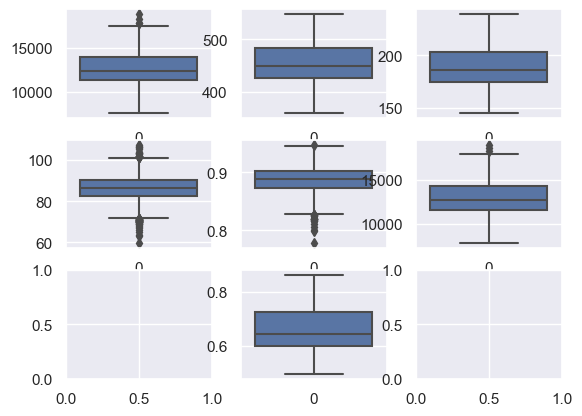

In [6]:
sns.set()
fig, axes = plt.subplots(3, 3)
numeric = ['area', 'perimeter', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'convex_area', 'extent']
ax = [axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1], axes[1,2], axes[2,1]]
for c, a in zip(numeric, ax):
    sns.boxplot(data=df[c], ax=a)

### Correlation

<AxesSubplot: >

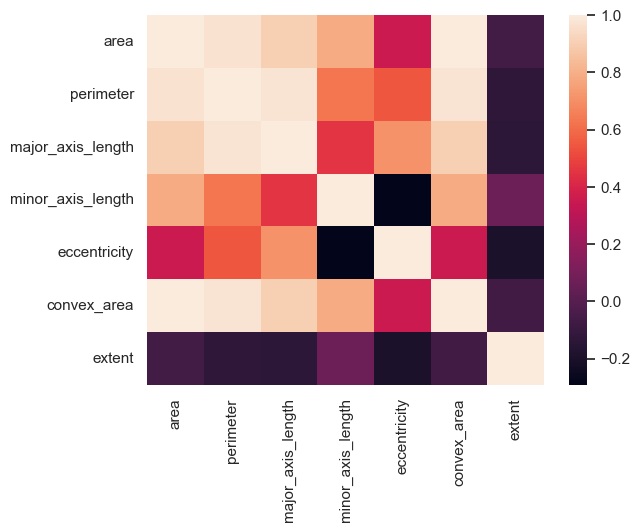

In [7]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr)

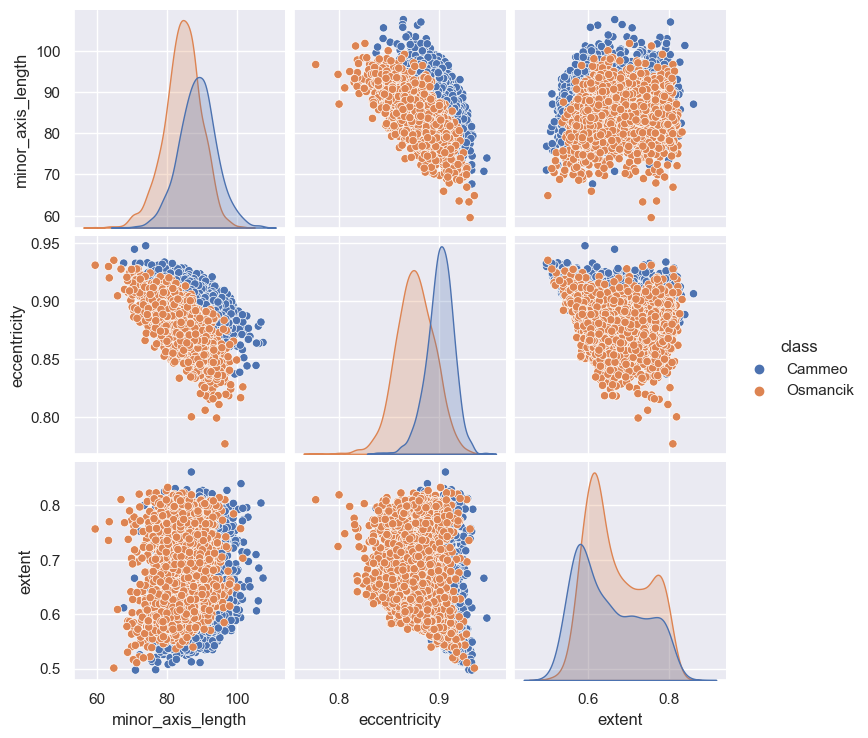

In [8]:
sns.pairplot(data = df, vars=['minor_axis_length','eccentricity','extent'], hue='class')

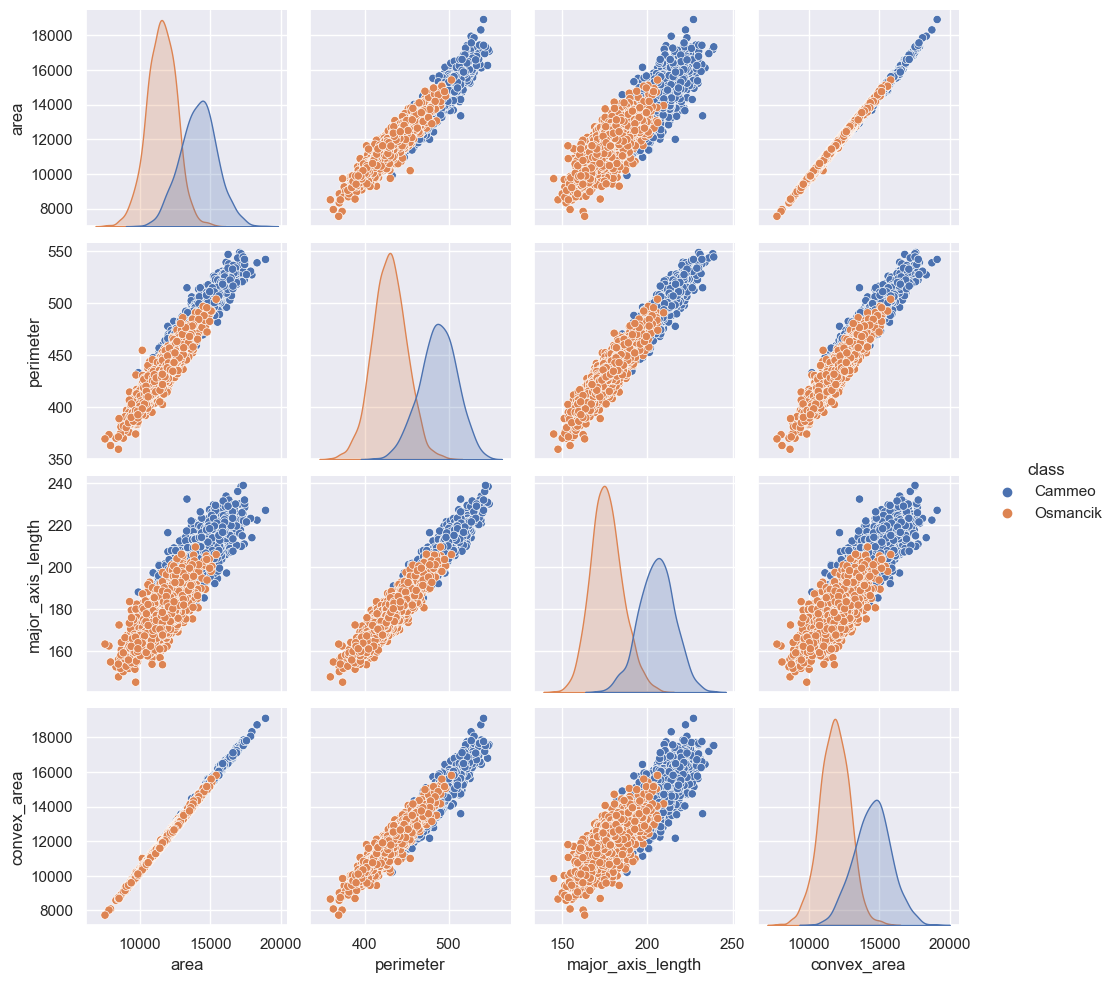

In [9]:
sns.pairplot(data = df, vars=['area','perimeter','major_axis_length','convex_area'], hue='class')

# Train

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

In [11]:
seed = 13
test_size = 0.25
n_kfolds = 4
max_iter=1000

kfold = KFold(n_splits=n_kfolds, shuffle=True, random_state=seed)

### Data preparation

In [12]:
df['class'] = df['class'].map(dict(Cammeo=0, Osmancik=1))

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.25, random_state=seed)

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_test = df_test['class'].values

del df_test['class']

### Logistic Regression

In [14]:
def train(X_train, y_train, C=1.0):
    model = LogisticRegression(C=C, max_iter=max_iter)
    model.fit(X_train, y_train)
    return model

def predict(df, model):
    y_pred = model.predict_proba(df)[:, 1]
    return y_pred

In [15]:
models = []
scores = []
idx = 0
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['class'].values
        y_val = df_val['class'].values
        
        del df_train['class']
        del df_val['class']

        model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, model)

        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((idx, C, auc))
        models.append(model)
        idx += 1

  0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
scores_sorted = sorted(scores, key=lambda s: s[2], reverse=True)
scores_sorted[:10]

[(13, 0.5, 0.9850963198509632),
 (21, 5, 0.9850802598508026),
 (17, 1, 0.9850401098504011),
 (25, 10, 0.9850401098504011),
 (9, 0.1, 0.9850160198501603),
 (5, 0.01, 0.9849517798495178),
 (1, 0.001, 0.9842371098423711),
 (12, 0.5, 0.9814793846950165),
 (8, 0.1, 0.981317632596283),
 (16, 1, 0.981317632596283)]

In [17]:
# Selected model (C=0.5)
logistic_regression_model = models[scores_sorted[0][0]]

### Decision Tree

In [18]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
min_samples_leaf = [1, 5, 10, 15, 20, 500, 100, 200, 500, 1000]

In [19]:
models = []
scores = []
idx = 0
for depth in depths:
    for samples in min_samples_leaf:
        for train_idx, val_idx in kfold.split(df_full_train):
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = df_train['class'].values
            y_val = df_val['class'].values
            
            del df_train['class']
            del df_val['class']
            
            model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples)
            model.fit(df_train, y_train)

            y_pred = model.predict_proba(df_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            
            scores.append((idx, depth, samples, auc))
            models.append(model)
            idx += 1

In [20]:
scores_sorted = sorted(scores, key=lambda s: s[3], reverse=True)
scores_sorted[:10]

[(145, 4, 100, 0.9803064248030642),
 (185, 5, 100, 0.9803064248030642),
 (225, 6, 100, 0.9803064248030642),
 (265, 10, 100, 0.9803064248030642),
 (305, 15, 100, 0.9803064248030642),
 (345, 20, 100, 0.9803064248030642),
 (385, None, 100, 0.9803064248030642),
 (144, 4, 100, 0.9798537761027448),
 (184, 5, 100, 0.9796798925966064),
 (224, 6, 100, 0.9796798925966064)]

In [21]:
# Selected model (depth=4, min_samples_leaf=100)
decision_tree_model = models[scores_sorted[0][0]]

### Random Forest

In [22]:
n_estimators = range(10, 501, 20)

In [23]:
models = []
scores = []
idx = 0
for n in n_estimators:
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['class'].values
        y_val = df_val['class'].values
        
        del df_train['class']
        del df_val['class']
        
        model = RandomForestClassifier(n_estimators=n, random_state=seed, min_samples_leaf=100, max_depth=10)
        model.fit(df_train, y_train)

        y_pred = model.predict_proba(df_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((idx, n, auc))
        models.append(model)
        idx += 1

In [24]:
scores_sorted = sorted(scores, key=lambda s: s[2], reverse=True)
scores_sorted[:10]

[(57, 290, 0.9816755398167554),
 (21, 110, 0.9816514498165145),
 (53, 270, 0.9816434198164342),
 (33, 170, 0.9816353898163539),
 (69, 350, 0.9816273598162735),
 (73, 370, 0.9816032698160329),
 (13, 70, 0.9815872098158722),
 (61, 310, 0.9815872098158721),
 (49, 250, 0.981587209815872),
 (97, 490, 0.9815791798157918)]

In [25]:
# Selected model (n_estimator=180)
random_forest_model = models[scores_sorted[0][0]]

# Evaluation

In [26]:
y_pred = logistic_regression_model.predict_proba(df_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred)

y_pred = decision_tree_model.predict_proba(df_test)[:, 1]
auc_dt = roc_auc_score(y_test, y_pred)

y_pred = random_forest_model.predict_proba(df_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred)

results = [('logistic_regresion', auc_lr), ('decision tree', auc_dt), ('random forest', auc_rf)]

sorted(results, key=lambda s: s[1], reverse=True)



[('logistic_regresion', 0.9775611501140276),
 ('random forest', 0.974645619997317),
 ('decision tree', 0.9719670884943881)]